# Load and Clean the Data

In [1]:
import requests, zipfile, io
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Get the College Scorecard data by year directly from the College Scorecard site as a zip file (file is too large for GitHub).

In [2]:
COLS = ['UNITID', 'INSTNM', 'CONTROL', 
        'MN_EARN_WNE_INC1_P10', 'MN_EARN_WNE_INC2_P10', 'MN_EARN_WNE_INC3_P10', 
        'LO_INC_COMP_ORIG_YR6_RT','LO_INC_COMP_4YR_TRANS_YR6_RT','LO_INC_COMP_2YR_TRANS_YR6_RT', 
        'NPT41_PUB', 'NPT41_PRIV']

DTYPES = {
    'UNITID': np.int64,
    'INSTNM': str,
    'CONTROL': np.int64,
    'MN_EARN_WNE_INC1_P10': np.float64,
    'MN_EARN_WNE_INC2_P10': np.float64,
    'MN_EARN_WNE_INC3_P10': np.float64,
    'LO_INC_COMP_ORIG_YR6_RT': np.float64,
    'LO_INC_COMP_4YR_TRANS_YR6_RT': np.float64,
    'LO_INC_COMP_2YR_TRANS_YR6_RT': np.float64,
    'NPT41_PUB': np.float64,
    'NPT41_PRIV': np.float64,
}

In [3]:
# Get College Scorecard data by year from Zip
r = requests.get('https://ed-public-download.app.cloud.gov/downloads/CollegeScorecard_Raw_Data.zip', stream=True)
if r.ok:
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extract('CollegeScorecard_Raw_Data/MERGED2014_15_PP.csv', path='data/')
else:
    print(f'Failed to get files: {r.status_code} {r.reason}')
# Get Data Dictionary
r = requests.get('https://collegescorecard.ed.gov/assets/CollegeScorecardDataDictionary.xlsx')
if r.ok:
    with open('data/CollegeScorecardDataDictionary.xlsx','wb') as dd:
        dd.write(r.content)
else:
    print(f'Failed to get file: {r.status_code} {r.reason}')
# Load data into pandas data frames
schools = pd.read_csv('data/CollegeScorecard_Raw_Data/MERGED2014_15_PP.csv',
                      low_memory=False, usecols=COLS, dtype=DTYPES, na_values=['PrivacySuppressed', 'NULL'])


In [4]:
schools.shape

(7766, 11)

In [5]:
schools.head()

,UNITID,INSTNM,CONTROL,NPT41_PUB,NPT41_PRIV,LO_INC_COMP_ORIG_YR6_RT,LO_INC_COMP_4YR_TRANS_YR6_RT,LO_INC_COMP_2YR_TRANS_YR6_RT,MN_EARN_WNE_INC1_P10,MN_EARN_WNE_INC2_P10,MN_EARN_WNE_INC3_P10
0,100654,Alabama A & M University,1,14601.0,NaN,0.325517,0.075862,NaN,33000.0,37300.0,39500.0
1,100663,University of Alabama at Birmingham,1,12453.0,NaN,0.478075,0.065241,0.020321,47000.0,49500.0,49300.0
2,100690,Amridge University,2,NaN,12992.0,0.364706,NaN,NaN,NaN,48800.0,NaN
3,100706,University of Alabama in Huntsville,1,15224.0,NaN,0.419660,0.081285,NaN,47000.0,55500.0,55100.0
4,100724,Alabama State University,1,10980.0,NaN,0.222323,0.083485,0.029946,29000.0,32500.0,34300.0


# Question 1: How do postgraduate earnings for low-income students differ across institutions by control? Is there a statistically significant difference?

The 3 variables that are most important to look at are:
- MN_EARN_WNE_INC1_P10 ("Mean earnings of students working and not enrolled 10 years after entry in the lowest income tercile `$0-$30,000`")
- MN_EARN_WNE_INC2_P10 ("Mean earnings of students working and not enrolled 10 years after entry in the middle income tercile `$30,001-$75,000`")
- MN_EARN_WNE_INC3_P10 ("Mean earnings of students working and not enrolled 10 years after entry in the highest income tercile `$75,001+`")

In [6]:
# Create a list of the variables
earnings_by_inc_tertile = ['MN_EARN_WNE_INC1_P10', 'MN_EARN_WNE_INC2_P10', 'MN_EARN_WNE_INC3_P10']

It is not immediately apparent from the data dictionary whether the income tertiles refer to the individual's income when they enrolled at the institution or at the 10-years-after-entry point. To evaluate this, we will describe each column.

In [9]:
schools[earnings_by_inc_tertile].describe()

,MN_EARN_WNE_INC1_P10,MN_EARN_WNE_INC2_P10,MN_EARN_WNE_INC3_P10
count,4999.000000,3710.000000,3737.000000
mean,35859.751950,43957.601078,48552.047097
std,14946.104069,12073.386197,13808.622423
min,14900.000000,20000.000000,22300.000000
25%,26600.000000,36400.000000,39500.000000
50%,32900.000000,42500.000000,46700.000000
75%,39900.000000,49075.000000,54500.000000
max,188300.000000,139300.000000,172100.000000


Given that the range of values do not line up with the tertiles discussed, it is safe to assume that the income tertiles describe the individual's income when they enrolled. Therefore, our first variable (MN_EARN_WNE_INC1_P10) denotes earnings for low-income students.

Let's start by comparing histograms by control and income tertile.

In [10]:
def hist_by_control_earnings(df: pd.DataFrame):
    '''
    Given a data frame, plot 3 histogram graphs side by side demonstrating the distribution 
    of average earnings 10 years out by original entry income tertile, with each graph being a control
    '''
    controls = {
        'Public': {'DF': df[df.CONTROL == 1], 'AX': None},
        'Nonprofit': {'DF': df[df.CONTROL == 2], 'AX': None},
        'Forprofit': {'DF': df[df.CONTROL == 3], 'AX': None},
    } # Create a dict of the DFs
    
    title = 'Mean earnings of students by control of institution and original entry income'
    fig, axes = plt.subplots(ncols=3, sharey=True, figsize=(15, 5)) # Create a 3-column subplot
    fig.suptitle(title, fontsize=16) # Set the title of the overall plot
    
    for ax in axes:
        ax.set_xlim(left=0, right=150000) # Set the x range to 0 to 150K
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45) # Rotate the x labels 45 degrees
        ax.set(ylabel='Percent of Students')

    for k, a in zip(tuple(controls.keys()), axes):
        controls[k]['AX'] = a # Add the corresponding axis to controls so we can use it when we iterate

    for k, v in controls.items():
        title = f'{k} Institutions'
        sns.distplot(v['DF'].MN_EARN_WNE_INC1_P10, bins=30, color='#1f3fb5', 
                     kde_kws={'label':'<$30K Income'}, ax=v['AX']).set_title(title)
        sns.distplot(v['DF'].MN_EARN_WNE_INC2_P10, bins=30, color='#b51d4d', 
                     kde_kws={'label':'$30K-75K Income'}, ax=v['AX'])
        sns.distplot(v['DF'].MN_EARN_WNE_INC3_P10, bins=30, color='#b8861c', 
                     kde_kws={'label':'>$75K Income'}, 
                     axlabel='Mean Income in US Dollars', ax=v['AX'])

/Users/jmaggie/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jmaggie/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jmaggie/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with simil

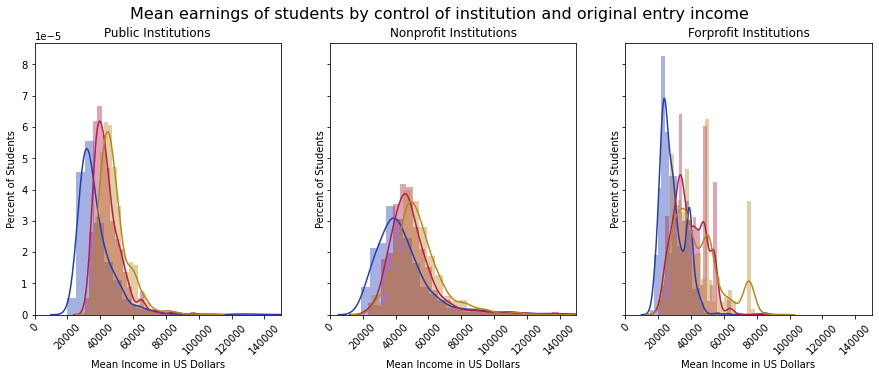

In [11]:
hist_by_control_earnings(schools)

From these histograms, it appears that the difference in mean earnings of students who attend public or private nonprofit institutions differs slightly but not drastically across original entry income tertiles. However, private forprofit institutions show a mode far lower for students whose original entry income tertile is under $30,000 as compared to the other two income tertiles.

I will explore this further by describing each and then doing a regression analysis to understand if the differences are statistically significant.

Null hypothesis = there is no difference in mean earnings for low-income students between institutions of different controls

In [12]:
schools.groupby('CONTROL')[earnings_by_inc_tertile].describe()

MN_EARN_WNE_INC1_P10                                                \
                       count          mean           std      min      25%   
CONTROL                                                                      
1                     1709.0  37850.614394  14175.339602  19500.0  30200.0   
2                     1190.0  45014.285714  19196.055830  19000.0  33500.0   
3                     2100.0  29052.000000   7909.588611  14900.0  23200.0   

                                    MN_EARN_WNE_INC2_P10                ...  \
             50%      75%       max                count          mean  ...   
CONTROL                                                                 ...   
1        34300.0  41500.0  188300.0               1225.0  44512.489796  ...   
2        40750.0  50775.0  173300.0               1079.0  49778.776645  ...   
3        27000.0  34425.0   85700.0               1406.0  39006.827881  ...   

                           MN_EARN_WNE_INC3_P10                              \
             75%       max                count          mean           std   
CONTROL                                                                       
1        48200.0  108600.0               1225.0  48608.897959   9166.988097   
2        55000.0  139300.0               1111.0  54220.252025  15534.301317   
3        48100.0   83100.0               1401.0  44007.423269  14066.738956   

                                                       
             min      25%      50%      75%       max  
CONTROL                                                
1        32000.0  42500.0  46400.0  52100.0  108800.0  
2        24700.0  45700.0  51600.0  60100.0  172100.0  
3        22300.0  33300.0  40600.0  50600.0   93200.0  

[3 rows x 24 columns]

The difference in median earnings across the tertiles is most pronounced in the difference between the lowest and middle tertiles for students who attended forprofit institutions, with a difference of over `$10,000`. 

Since I am most concerned with low-income students, I will narrow in on the differences between MN_EARN_WNE_INC1_P10 (mean earnings of students in the lowest income tertile). There is a drastic difference between the means according to these tables, with students who attended public institutions on average making `$37852`, students who attend nonprofit institutions on average making `$45014`, and students who attend forprofit institutions making a measly `$29058`.

It is particularly interesting that the median earnings of students with original entry income below `$30,000` is `$27,000`. This demonstrates that most low-income students who attend forprofit institutions are not able to increase their income as a result of their education.

To understand if there is a statistically significant difference between the mean earnings for students in the lowest income tertile by institutional control, I will do an ANOVA.

In [13]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [14]:
# model mean earnings of lowest income tertile students on institutional control as a categorical variable
model = smf.ols('MN_EARN_WNE_INC1_P10 ~ C(CONTROL)', data=schools).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     MN_EARN_WNE_INC1_P10   R-squared:                       0.183
Model:                              OLS   Adj. R-squared:                  0.182
Method:                   Least Squares   F-statistic:                     557.9
Date:                  Wed, 25 Nov 2020   Prob (F-statistic):          2.05e-219
Time:                          16:04:56   Log-Likelihood:                -54640.
No. Observations:                  4999   AIC:                         1.093e+05
Df Residuals:                      4996   BIC:                         1.093e+05
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        3.785e+04    326.942    115.772      0.000    3.72e+04    3.85e+04
C(CONTROL)[T.2]  7163.6713    510.296     14.038      0.000    6163.268    8164.075
C(CONTROL)[T.3] -8798.6144    440.319    -19.982      0.000   -9661.832   -7935.397
==============================================================================
Omnibus:                     3846.345   Durbin-Watson:                   1.569
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           111286.707
Skew:                           3.434   Prob(JB):                         0.00
Kurtosis:                      25.071   Cond. No.                         3.78
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
aov_table = sm.stats.anova_lm(model, typ=2)
print(aov_table)

                  sum_sq      df           F         PR(>F)
C(CONTROL)  2.038277e+11     2.0  557.890245  2.050196e-219
Residual    9.126556e+11  4996.0         NaN            NaN


The probability of an F statistic of 555.35 is 1.784662e-218 which is MUCH less than 0.05, meaning that the probability that the differences between the mean values of mean earnings of students in the lowest income tertile across institutional controls occurred by chance is essentially 0. In short, the difference we saw in mean earnings of students in the lowest income tertile across instutional controls is stastically significant--we reject our null hypothesis.

# Question 2: Are low-income students more likely to complete a degree (either at the original institution or after transferring to another institution) in 6 years at an institution of one control as compared to another?

The 3 variables that are most important to look at are:
- LO_INC_COMP_ORIG_YR6_RT ("Percent of low-income (less than `$30,000` in nominal family income) students who completed within 6 years at original institution")
- LO_INC_COMP_4YR_TRANS_YR6_RT ("Percent of low-income (less than `$30,000` in nominal family income) students who transferred to a 4-year institution and completed within 6 years")
- LO_INC_COMP_2YR_TRANS_YR6_RT ("Percent of low-income (less than `$30,000` in nominal family income) students who transferred to a 2-year institution and completed within 6 years")

In [16]:
# Create a list of the variables
lo_inc_comp = ['LO_INC_COMP_ORIG_YR6_RT','LO_INC_COMP_4YR_TRANS_YR6_RT','LO_INC_COMP_2YR_TRANS_YR6_RT']

In [17]:
# Check the data types
schools[lo_inc_comp].dtypes

LO_INC_COMP_ORIG_YR6_RT         float64
LO_INC_COMP_4YR_TRANS_YR6_RT    float64
LO_INC_COMP_2YR_TRANS_YR6_RT    float64
dtype: object

In [18]:
# Convert to numeric
for v in lo_inc_comp:
    schools[v] = pd.to_numeric(schools[v])

In [19]:
# Inspect the variables to ensure they have sufficient data
schools[lo_inc_comp].describe()

,LO_INC_COMP_ORIG_YR6_RT,LO_INC_COMP_4YR_TRANS_YR6_RT,LO_INC_COMP_2YR_TRANS_YR6_RT
count,5401.000000,2877.000000,2150.000000
mean,0.415620,0.068330,0.036502
std,0.200615,0.036547,0.018059
min,0.009615,0.006477,0.005479
25%,0.253521,0.041558,0.025132
50%,0.430000,0.062048,0.032192
75%,0.579545,0.087886,0.046736
max,0.955932,0.286624,0.307943


In [20]:
# Create a new variable with these percents added together--require a non-null value in at least 2 columns
schools['LO_INC_COMP_ORIG_OR_TRANS_YR6'] = schools[lo_inc_comp].sum(axis=1, min_count=2)

In [21]:
# Create a second list with the new variable
lo_inc_comp_plus = lo_inc_comp + ['LO_INC_COMP_ORIG_OR_TRANS_YR6']

In [22]:
schools[lo_inc_comp_plus].describe() # Inspect to ensure it worked

,LO_INC_COMP_ORIG_YR6_RT,LO_INC_COMP_4YR_TRANS_YR6_RT,LO_INC_COMP_2YR_TRANS_YR6_RT,LO_INC_COMP_ORIG_OR_TRANS_YR6
count,5401.000000,2877.000000,2150.000000,3050.000000
mean,0.415620,0.068330,0.036502,0.406621
std,0.200615,0.036547,0.018059,0.163903
min,0.009615,0.006477,0.005479,0.079829
25%,0.253521,0.041558,0.025132,0.275320
50%,0.430000,0.062048,0.032192,0.361357
75%,0.579545,0.087886,0.046736,0.549190
max,0.955932,0.286624,0.307943,0.926829


In [23]:
# Round the new variable so we can treat it as categorical
schools['LO_INC_COMP_ORIG_OR_TRANS_YR6_ROUND'] = schools['LO_INC_COMP_ORIG_OR_TRANS_YR6'].round(1)
lo_inc_comp_plus.append('LO_INC_COMP_ORIG_OR_TRANS_YR6_ROUND')

In [24]:
schools[lo_inc_comp_plus].describe() # Inspect to ensure it worked

,LO_INC_COMP_ORIG_YR6_RT,LO_INC_COMP_4YR_TRANS_YR6_RT,LO_INC_COMP_2YR_TRANS_YR6_RT,LO_INC_COMP_ORIG_OR_TRANS_YR6,LO_INC_COMP_ORIG_OR_TRANS_YR6_ROUND
count,5401.000000,2877.000000,2150.000000,3050.000000,3050.000000
mean,0.415620,0.068330,0.036502,0.406621,0.404918
std,0.200615,0.036547,0.018059,0.163903,0.167894
min,0.009615,0.006477,0.005479,0.079829,0.100000
25%,0.253521,0.041558,0.025132,0.275320,0.300000
50%,0.430000,0.062048,0.032192,0.361357,0.400000
75%,0.579545,0.087886,0.046736,0.549190,0.500000
max,0.955932,0.286624,0.307943,0.926829,0.900000


I've now created a variable that sums the completion rates for low-income students so that the variable shows the percent of low-income students who complete a degree at the original institution OR after transferring. We will use this in a chi-square test.

Null hypothesis = there is no difference in completion rates based on institutional control

In [25]:
# Create a crosstab
ct = pd.crosstab(schools.CONTROL, schools.LO_INC_COMP_ORIG_OR_TRANS_YR6_ROUND,
                normalize='index')
ct

LO_INC_COMP_ORIG_OR_TRANS_YR6_ROUND,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
CONTROL,,,,,,,,,
1,0.027378,0.211095,0.306196,0.174352,0.110231,0.107349,0.054035,0.009366,0.000000
2,0.003279,0.059016,0.121311,0.167213,0.259016,0.214754,0.118033,0.052459,0.004918
3,0.004753,0.183460,0.379278,0.105513,0.055133,0.191065,0.076046,0.004753,0.000000


[Text(0.5, 15.0, 'Low Income Student 6-Year Completion Rate'),
 Text(33.0, 0.5, 'Control')]

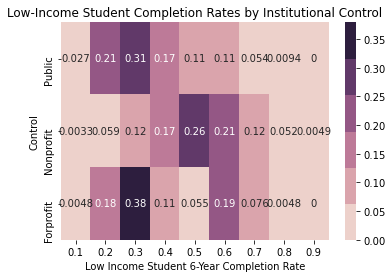

In [26]:
a = sns.heatmap(ct,annot=True,cmap=sns.cubehelix_palette(), yticklabels=['Public','Nonprofit','Forprofit'])
a.set_title('Low-Income Student Completion Rates by Institutional Control')
a.set(xlabel='Low Income Student 6-Year Completion Rate', ylabel='Control')

In [27]:
from scipy.stats import chi2_contingency
chi2, p, dof, ex = chi2_contingency(ct)
print("chi2 = ", chi2)
print("p-val = ", p)
print("degree of freedom = ", dof)

chi2 =  0.5607321222406833
p-val =  0.9999999992617195
degree of freedom =  16


Since our p-value is very small (close to 0), we can reject our null hypothesis and conclude that there is a difference in completion rates based on institutional control.

In [28]:
schools.groupby('CONTROL').LO_INC_COMP_ORIG_OR_TRANS_YR6.describe()

,count,mean,std,min,25%,50%,75%,max
CONTROL,,,,,,,,
1,1388.0,0.371854,0.155068,0.079829,0.252961,0.331918,0.483653,0.848504
2,610.0,0.503803,0.150866,0.138021,0.396247,0.502675,0.615314,0.926829
3,1052.0,0.396142,0.160699,0.081323,0.272941,0.334404,0.552245,0.781481


# Question 3: What is the relationship between the control/ownership of the institution and net price for low-income students? Do low-income students pay more to go to one type of institution as compared to another?

The 2 variables that are important to look at are:
- NPT41_PUB ("Average net price for `$0-$30,000` family income (public institutions)")
- NPT41_PRIV ("Average net price for `$0-$30,000` family income (private for-profit and nonprofit institutions)")

In [29]:
cost_low_inc = ['NPT41_PUB', 'NPT41_PRIV']

In [30]:
schools[cost_low_inc].dtypes # Check data type

NPT41_PUB     float64
NPT41_PRIV    float64
dtype: object

In [31]:
schools[cost_low_inc].describe()

,NPT41_PUB,NPT41_PRIV
count,1909.000000,4650.000000
mean,8003.248821,16738.136774
std,3900.793908,6725.642860
min,-2434.000000,-5686.000000
25%,5434.000000,12207.500000
50%,7526.000000,16660.000000
75%,10083.000000,21002.500000
max,24647.000000,88336.000000


In [32]:
# Ensure these columns are independent and have no overlap
len(schools[~schools.NPT41_PUB.isnull() & ~schools.NPT41_PRIV.isnull()])

0

In [33]:
# Make 1 column with all of the net price data
schools['NPT41_ALL'] = schools[cost_low_inc].sum(axis=1)

Visualize the difference between average net price of attendance for low-income students by institutional control using a violin plot.

Text(0.5, 1.0, 'Average net price for low-income students by institutional control')

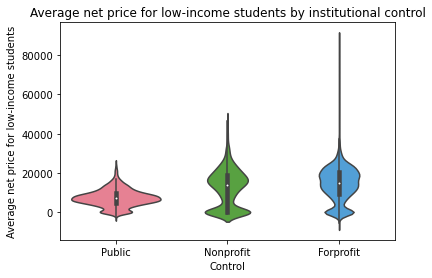

In [34]:
sns.violinplot(x=schools['CONTROL'], y=schools['NPT41_ALL'], palette='husl')
plt.xlabel('Control')
plt.ylabel('Average net price for low-income students')
plt.xticks(np.arange(3),['Public','Nonprofit','Forprofit'])
plt.title('Average net price for low-income students by institutional control')

In [35]:
# Further inspect using a summary table
schools.groupby('CONTROL')['NPT41_ALL'].describe()

,count,mean,std,min,25%,50%,75%,max
CONTROL,,,,,,,,
1,2056.0,7431.032101,4287.419445,-2434.0,4827.75,7167.5,9780.5,24647.0
2,1993.0,12231.745610,9357.949805,-708.0,0.00,13938.0,18815.0,46416.0
3,3717.0,14381.078020,8550.863828,-5686.0,9192.00,15040.0,20401.0,88336.0


Determine if the difference is statistically significant

Null hypothesis = there is no difference between the average net price for low-income students across institutional controls

In [36]:
# model average net price for low-income students on institutional control as a categorical variable
model2 = smf.ols('NPT41_ALL ~ C(CONTROL)', data=schools).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              NPT41_ALL   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     514.1
Date:                Wed, 25 Nov 2020   Prob (F-statistic):          2.05e-210
Time:                        16:04:57   Log-Likelihood:                -80710.
No. Observations:                7766   AIC:                         1.614e+05
Df Residuals:                    7763   BIC:                         1.614e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        7431.0321    174.125     42.676      0.000    7089.700    7772.364
C(CONTROL)[T.2]  4800.7135    248.188     19.343      0.000    4314.198    5287.229
C(CONTROL)[T.3]  6950.0459    217.003     32.027      0.000    6524.662    7375.430
==============================================================================
Omnibus:                      379.197   Durbin-Watson:                   1.505
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1105.196
Skew:                           0.215   Prob(JB):                    1.02e-240
Kurtosis:                       4.797   Cond. No.                         4.25
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The p-value is nearly 0, meaning the probability that the differences occurred by chance is nearly 0. Therefore, we can reject the null hypothesis and conclude that there is a statistically significant difference in net price by institutional control.

# Question 4: When clustering institutions based on the attributes used in the above three questions, what trends can be seen in institutions that are clustered together?

To identify like institutions based on the variables used in questions \#1-3, I decided to use Agglomerative Clustering so that I can identify a reasonable number of clusters based on the dendogram plot.

In [37]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import KMeans

In [38]:
cols = ['MN_EARN_WNE_INC1_P10','LO_INC_COMP_ORIG_OR_TRANS_YR6','NPT41_ALL'] # List of primary columns used in #1-3

In [39]:
schools_sliced = schools[cols] # Create a dataset with only those columns
schools_sliced_nona = schools_sliced.dropna(how='any') # Drop rows with any null values for the clustering

In [40]:
len(schools_sliced_nona) # Check how many rows are left

3022

In [41]:
model3 = AgglomerativeClustering(n_clusters=5)
model3.fit_predict(schools_sliced_nona)

array([1, 3, 1, ..., 3, 3, 2])

In [42]:
schools_sliced_nona['cluster'] = model3.labels_

<ipython-input-42-c74500fd57b4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  schools_sliced_nona['cluster'] = model3.labels_


In [43]:
def plot_dendrogram(model, **kwargs):
    '''
    Plot the corresponding dendrogram of a hierarchical clustering using AgglomerativeClustering 
    and the dendrogram method available in scipy.
    
    Credit: Mathew Kallada, Chris Teplovs. License: BSD clause.
    '''

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

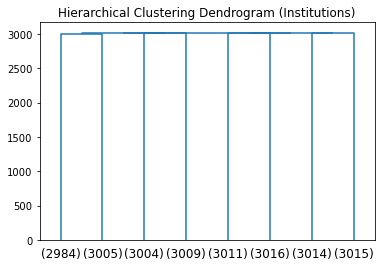

In [44]:
plt.title('Hierarchical Clustering Dendrogram (Institutions)')
plot_dendrogram(model3, labels=model3.labels_, truncate_mode='level', p=2)
plt.show()

I decided on 8 (large) clusters based on this dendogram. For the purpose of this analysis since I plan to explain each cluster, fewer clusters with many observations in each is more reasonable than many clusters with fewer observations in each.

In [45]:
model3 = AgglomerativeClustering(n_clusters=8) # Redo the model with 8 clusters
model3.fit_predict(schools_sliced_nona) # Fit the model to the dataset
schools_sliced_nona['cluster'] = model3.labels_ # Add the cluster labels to the data frame

<ipython-input-45-bdb2daa95a6f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  schools_sliced_nona['cluster'] = model3.labels_ # Add the cluster labels to the data frame


In [46]:
schools_sliced_nona.head()

,MN_EARN_WNE_INC1_P10,LO_INC_COMP_ORIG_OR_TRANS_YR6,NPT41_ALL,cluster
0,33000.0,0.401379,14601.0,2
1,47000.0,0.563636,12453.0,1
3,47000.0,0.500945,15224.0,2
4,29000.0,0.335753,10980.0,0
5,45500.0,0.569588,17957.0,2


In [47]:
schools['cluster'] = schools_sliced_nona['cluster'] # Add the cluster labels to the original data frame

In [48]:
schools.head()

,UNITID,INSTNM,CONTROL,NPT41_PUB,NPT41_PRIV,LO_INC_COMP_ORIG_YR6_RT,LO_INC_COMP_4YR_TRANS_YR6_RT,LO_INC_COMP_2YR_TRANS_YR6_RT,MN_EARN_WNE_INC1_P10,MN_EARN_WNE_INC2_P10,MN_EARN_WNE_INC3_P10,LO_INC_COMP_ORIG_OR_TRANS_YR6,LO_INC_COMP_ORIG_OR_TRANS_YR6_ROUND,NPT41_ALL,cluster
0,100654,Alabama A & M University,1,14601.0,NaN,0.325517,0.075862,NaN,33000.0,37300.0,39500.0,0.401379,0.4,14601.0,2.0
1,100663,University of Alabama at Birmingham,1,12453.0,NaN,0.478075,0.065241,0.020321,47000.0,49500.0,49300.0,0.563636,0.6,12453.0,1.0
2,100690,Amridge University,2,NaN,12992.0,0.364706,NaN,NaN,NaN,48800.0,NaN,NaN,NaN,12992.0,NaN
3,100706,University of Alabama in Huntsville,1,15224.0,NaN,0.419660,0.081285,NaN,47000.0,55500.0,55100.0,0.500945,0.5,15224.0,2.0
4,100724,Alabama State University,1,10980.0,NaN,0.222323,0.083485,0.029946,29000.0,32500.0,34300.0,0.335753,0.3,10980.0,0.0


In [49]:
schools_clustered = schools[~schools.cluster.isnull()]

In [50]:
schools_clustered.groupby('cluster')['cluster'].count() # See how many institutions in each cluster

cluster
0.0    993
1.0    534
2.0    360
3.0    109
4.0    551
5.0    152
6.0     20
7.0    303
Name: cluster, dtype: int64

The next step is exploring the clusters. I will start with a violin plot to understand the relationship between the clusters and controls.

Text(0.5, 1.0, 'Institutions by cluster and control')

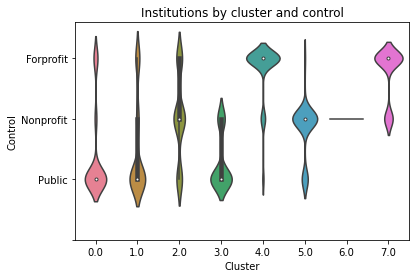

In [51]:
sns.violinplot(x=schools_clustered['cluster'], y=schools_clustered['CONTROL'], palette='husl')
plt.xlabel('Cluster')
plt.ylabel('Control')
plt.yticks(np.arange(4),['','Public','Nonprofit','Forprofit'])
plt.title('Institutions by cluster and control')

It looks like clusters 0, 1, and 3 are mostly public institutions, clusters 4 and 6 are mostly for-profit institutions, clusters 5 and 6 are mostly nonprofit institutions, and cluster 2 is fairly evenly distributed between all 3 controls.

Next, I'll look at a pair plot for the most important variables related to low-income students.

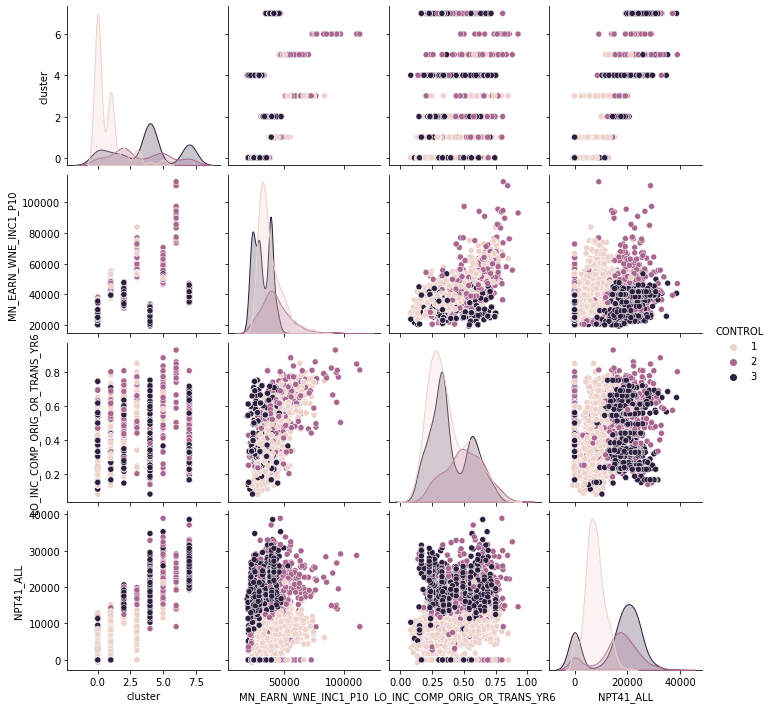

In [52]:
sns.pairplot(schools_clustered,vars=['cluster',
                                     'MN_EARN_WNE_INC1_P10',
                                     'LO_INC_COMP_ORIG_OR_TRANS_YR6',
                                     'NPT41_ALL'], hue='CONTROL')
plt.savefig('pair.png',format='png')

It looks like there is a strong relationship between cluster and earnings as well as cluster and cost, but not as strong a relationship between cluster and completion rate. To confirm this theory, I will look at violin plots for each cluster and variable.

Text(0.5, 1.0, 'Institutions by cluster and mean earnings of low-income students')

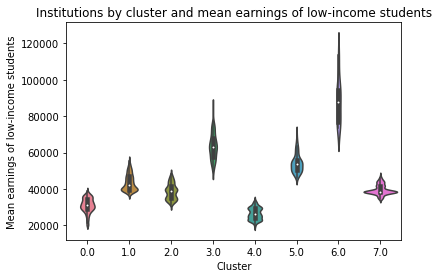

In [53]:
# Further investigate the relationship between cluster and mean earnings of low-income students
sns.violinplot(x=schools_clustered['cluster'], y=schools_clustered['MN_EARN_WNE_INC1_P10'], 
               palette='husl')
plt.xlabel('Cluster')
plt.ylabel('Mean earnings of low-income students')
plt.title('Institutions by cluster and mean earnings of low-income students')

Text(0.5, 1.0, 'Institutions by cluster and completion rate for low-income students')

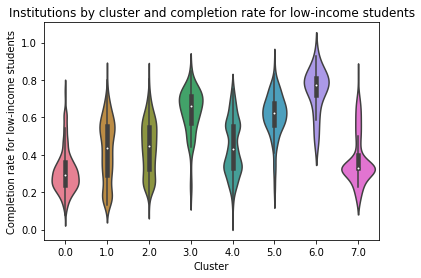

In [54]:
# Further investigate the relationship between cluster and 6-year completion rate for low-income students
sns.violinplot(x=schools_clustered['cluster'], y=schools_clustered['LO_INC_COMP_ORIG_OR_TRANS_YR6'], 
               palette='husl')
plt.xlabel('Cluster')
plt.ylabel('Completion rate for low-income students')
plt.title('Institutions by cluster and completion rate for low-income students')

Text(0.5, 1.0, 'Institutions by cluster and mean net price for low-income students')

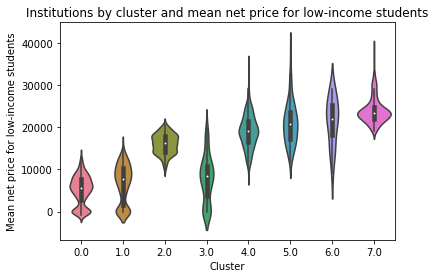

In [55]:
# Further investigate the relationship between cluster and mean net price for low-income students
sns.violinplot(x=schools_clustered['cluster'], y=schools_clustered['NPT41_ALL'], 
               palette='husl')
plt.xlabel('Cluster')
plt.ylabel('Mean net price for low-income students')
plt.title('Institutions by cluster and mean net price for low-income students')

The below table roughly describes each cluster, with color-coding for the 3 continuous variables to quickly see the differences between clusters:
- <mark style="background-color:#ffc2c2">red = bad</mark>
- <mark style="background-color:#ffffc4">yellow = mid</mark>
- <mark style="background-color:#c8ffc2">green=good</mark>
- <mark style="background-color:#cfcfcf">gray=relationship between cluster and variable not meaningful enough to specify, as defined by a box (quartiles) that appear to span more than 20% of the available range and don’t neatly fall into a bad/mid/good bucket</mark>

| Cluster | Control | Mean earnings (10 year) for low-income students (<mark style="background-color:#ffc2c2">Bad = low, median `<$40K`</mark>, <mark style="background-color:#c8ffc2">Good = high, median `>$60K`</mark>) | 6-year completion rate for low-income students (<mark style="background-color:#ffc2c2">Bad = low, median <30%</mark>, <mark style="background-color:#c8ffc2">Good = high, median >60%</mark>) | Mean net price for low-income students (<mark style="background-color:#ffc2c2">Bad = high, median `>$20K`</mark>, <mark style="background-color:#c8ffc2">Good = low, median `<$10K`</mark>) |
|---------|------------------------------|------------------------------|------------------------------|------------------------------|
| 0 | Primarily public, but includes institutions of all 3 controls | <mark style="background-color:#ffc2c2">Low, Median `~$31K`</mark> | <mark style="background-color:#ffc2c2">Low, Median ~28%</mark> | <mark style="background-color:#c8ffc2">Low, Median `~$5K`</mark> |
| 1 | Primarily public, but includes institutions of all 3 controls | <mark style="background-color:#ffffc4">Mid, Median `~$41K`</mark> | <mark style="background-color:#cfcfcf">Minimal relationship between cluster and completion, Median ~45%</mark> | <mark style="background-color:#c8ffc2">Low, Median `~$8K`</mark> |
| 2 | Fairly evenly distributed across all 3 controls; however, the largest number of nonprofit institutions in any cluster is in this one | <mark style="background-color:#ffffc4">Mid, Median `~$40K`</mark> | <mark style="background-color:#cfcfcf">Minimal relationship between cluster and completion, Median ~45%</mark> | <mark style="background-color:#ffffc4">Mid, Median `~$15K`</mark> |
| 3 | Primarily public, but also includes nonprofit; no for-profit | <mark style="background-color:#c8ffc2">High, Median `~$65K`</mark> | <mark style="background-color:#c8ffc2">High, Median ~65%</mark> | <mark style="background-color:#c8ffc2">Low, Median `~$9K`</mark> |
| 4 | Primarily for-profit, but includes institutions of all 3 controls | <mark style="background-color:#ffc2c2">Low, Median `~$28K`</mark> | <mark style="background-color:#cfcfcf">Minimal relationship between cluster and completion, Median ~40%</mark> | <mark style="background-color:#ffffc4">Mid, Median `~$19K`</mark> |
| 5 | Primarily nonprofit, but includes institutions of all 3 controls | <mark style="background-color:#ffffc4">Mid, Median `~$52K`</mark> | <mark style="background-color:#c8ffc2">High, Median ~62%</mark> | <mark style="background-color:#ffc2c2">High, Median `~$20K`</mark> |
| 6 | All nonprofit | <mark style="background-color:#c8ffc2">High, Median `~$85K`</mark> | <mark style="background-color:#c8ffc2">High, Median ~75%</mark> | <mark style="background-color:#ffc2c2">High, Median `~$22K`</mark> |
| 7 | Primarily for-profit, but also includes nonprofit; no public | <mark style="background-color:#ffffc4">Mid, Median `~$40K`</mark> | <mark style="background-color:#ffffc4">Mid, Median ~30%</mark> | <mark style="background-color:#ffc2c2">High, Median `~$23K`</mark> |

The most interesting clusters (i.e. extreme values) based on the above table are:
- 0, because it has the one of the poorest ROIs of any cluster, with a bad rating in earnings and completion rate (in fact, the poorest completion rate of any cluster), but a good rating in cost (in fact, the lowest cost of any cluster). I predict that this cluster contains many community colleges--public institutions that tend to be inexpensive but lead to lower earnings and have poor completion rates as compared to other institutions.
- 3, because it has the best ROI of any cluster, with good ratings in all 3 categories. I predict that this cluster contains many elite public and nonprofit institutions, such as the University of Michigan and the Ivies, which tend to lead to good earnings and completion rates and also significantly fund low-income students.
- 4, because it has one of the poorest ROIs of any cluster, with the lowest median earnings of any cluster and a higher-end-of-mid rating for cost. I predict that this cluster contains many trade schools for trades that tend to earn less, such as massage and beauty schools.
- 6, because it has the best median earnings and best median completion rate of any cluster, but the second-worst median cost. Additionally, there are only 20 institutions in this cluster, when the next smallest cluster has over 100. What could be so special about these institutions? I do not have a prediction for the institutions in this cluster.
- 7, because it has the one of the poorest ROIs of any cluster, with lower-end-of-mid ratings for earnings and completion and the highest median cost of any cluster. I predict that this cluster contains many of the classic "predatory" for-profit institutions, such as ITT Tech.

To further investigate my predictions and findings, I will determine the most commonly used words in the names of institutions in each cluster.

In [56]:
# For fun, check where U-M fell to see if I was right
schools[schools.INSTNM == 'University of Michigan-Ann Arbor'].cluster

1841    3.0
Name: cluster, dtype: float64

In [57]:
schools_name = schools[['INSTNM', 'cluster']] # Slice out only the name and cluster

In [58]:
from nltk import word_tokenize as tokenize
from nltk.corpus import stopwords
from collections import Counter

In [59]:
schools_name['tokens'] = schools_name.INSTNM.apply(lambda x: tokenize(x))

<ipython-input-59-f1de7f8bd782>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  schools_name['tokens'] = schools_name.INSTNM.apply(lambda x: tokenize(x))


In [60]:
schools_name.head()

,INSTNM,cluster,tokens
0,Alabama A & M University,2.0,"[Alabama, A, &, M, University]"
1,University of Alabama at Birmingham,1.0,"[University, of, Alabama, at, Birmingham]"
2,Amridge University,NaN,"[Amridge, University]"
3,University of Alabama in Huntsville,2.0,"[University, of, Alabama, in, Huntsville]"
4,Alabama State University,0.0,"[Alabama, State, University]"


In [61]:
# Create a set of stopwords to remove
S = set(stopwords.words('english')) # Use Set so that we can check if the token is in the entirety of S
S.add('&')

In [62]:
def remove_stops(token_list: list):
    '''
    Given a list of tokens, return a list of tokens with stop words removed
    '''
    words_stop_removed = []
    for token in token_list:
        if not token.lower() in S:
            words_stop_removed.append(token.lower())
    return words_stop_removed

In [63]:
schools_name['tokens_no_stop'] = schools_name.tokens.apply(lambda x: remove_stops(x))

<ipython-input-63-c17ee72b8135>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  schools_name['tokens_no_stop'] = schools_name.tokens.apply(lambda x: remove_stops(x))


In [64]:
schools_name.head()

,INSTNM,cluster,tokens,tokens_no_stop
0,Alabama A & M University,2.0,"[Alabama, A, &, M, University]","[alabama, university]"
1,University of Alabama at Birmingham,1.0,"[University, of, Alabama, at, Birmingham]","[university, alabama, birmingham]"
2,Amridge University,NaN,"[Amridge, University]","[amridge, university]"
3,University of Alabama in Huntsville,2.0,"[University, of, Alabama, in, Huntsville]","[university, alabama, huntsville]"
4,Alabama State University,0.0,"[Alabama, State, University]","[alabama, state, university]"


In [65]:
schools_name_nona = schools_name[~schools_name.cluster.isnull()]
len(schools_name_nona)

3022

In [66]:
freq=pd.DataFrame()

for row in schools_name_nona.index:
    counts = Counter(schools_name_nona.loc[row]['tokens_no_stop'])
    df = pd.DataFrame(counts, index=[row])
    df['cluster'] = schools_name_nona['cluster']
    freq = freq.append(df)

In [67]:
freq.shape

(3022, 2483)

In [68]:
def plot_common(df: pd.DataFrame, cluster):
    '''
    Given a data frame of counts of words in bodies of text and a cluster to filter to,
    construct a bar plot of the most common words used and their counts
    '''
    x = 'Token' # Create standard X axis for the plot
    y = 'Number of Times Used' # Create standard Y axis for the plot
    
    clustered_df = df[ df.cluster == cluster ]
    sums = clustered_df.sum(axis=0)
    sums_df = pd.DataFrame(sums, columns=[y])
    sums_df.drop(['cluster'], axis=0, inplace=True)
    sorted_df = sums_df.sort_values(y, ascending=False)[:10]
    sorted_df.reset_index(inplace=True)
    sorted_df.rename(columns={'index':x}, inplace=True)
    
    title = f'Top 10 Tokens Used in Cluster {cluster} Institution Names'
    plot = sns.barplot(x=x, y=y, data=sorted_df)
    plot.set_title(title)
    plot.set_xticklabels(plot.get_xticklabels(), rotation=45)

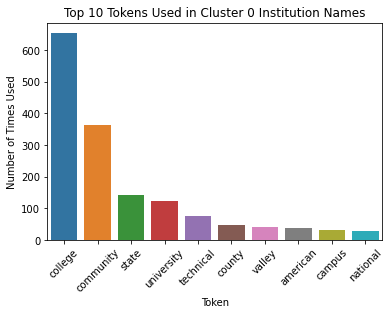

In [69]:
plot_common(freq, 0)

In [70]:
# Randomly sample 10 schools to spot check
schools[schools.cluster == 0].sample(10)

,UNITID,INSTNM,CONTROL,NPT41_PUB,NPT41_PRIV,LO_INC_COMP_ORIG_YR6_RT,LO_INC_COMP_4YR_TRANS_YR6_RT,LO_INC_COMP_2YR_TRANS_YR6_RT,MN_EARN_WNE_INC1_P10,MN_EARN_WNE_INC2_P10,MN_EARN_WNE_INC3_P10,LO_INC_COMP_ORIG_OR_TRANS_YR6,LO_INC_COMP_ORIG_OR_TRANS_YR6_ROUND,NPT41_ALL,cluster
2782,199494,Rowan-Cabarrus Community College,1,5418.0,NaN,0.034483,0.068124,0.026072,25300.0,NaN,NaN,0.128680,0.1,5418.0,0.0
7678,44098902,Texas Barber College - Branch Campus #2,3,NaN,NaN,0.441919,NaN,0.056818,25000.0,NaN,NaN,0.498737,0.5,0.0,0.0
2372,188438,Adirondack Community College,1,4412.0,NaN,0.235294,0.052036,0.040724,32400.0,37400.0,39800.0,0.328054,0.3,4412.0,0.0
3302,213525,Lehigh Carbon Community College,1,4336.0,NaN,0.192702,0.064994,0.071836,32500.0,38400.0,40200.0,0.329532,0.3,4336.0,0.0
4064,236513,Seattle Central College,1,4534.0,NaN,0.089498,0.125114,NaN,35000.0,NaN,NaN,0.214612,0.2,4534.0,0.0
7516,16947904,Davenport University-Kalamazoo Location,2,NaN,NaN,0.158723,0.035272,0.041468,28300.0,39900.0,47700.0,0.235462,0.2,0.0,0.0
1832,170620,Lake Michigan College,1,4830.0,NaN,0.125166,0.053262,NaN,25700.0,NaN,NaN,0.178429,0.2,4830.0,0.0
220,110246,Butte College,1,4174.0,NaN,0.048847,0.093623,0.020353,34400.0,41700.0,54500.0,0.162822,0.2,4174.0,0.0
15,101161,Coastal Alabama Community College,1,5687.0,NaN,0.111628,0.101163,0.043023,29700.0,37900.0,38600.0,0.255814,0.3,5687.0,0.0
3969,233116,Piedmont Virginia Community College,1,5517.0,NaN,0.205074,0.080338,NaN,31800.0,NaN,NaN,0.285412,0.3,5517.0,0.0


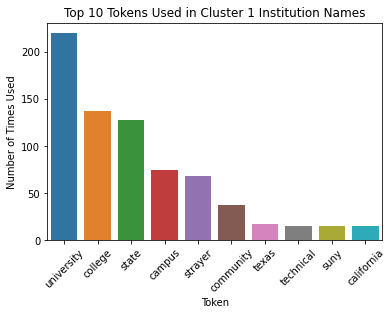

In [71]:
plot_common(freq, 1)

In [72]:
schools[schools.cluster == 1].sample(10)

,UNITID,INSTNM,CONTROL,NPT41_PUB,NPT41_PRIV,LO_INC_COMP_ORIG_YR6_RT,LO_INC_COMP_4YR_TRANS_YR6_RT,LO_INC_COMP_2YR_TRANS_YR6_RT,MN_EARN_WNE_INC1_P10,MN_EARN_WNE_INC2_P10,MN_EARN_WNE_INC3_P10,LO_INC_COMP_ORIG_OR_TRANS_YR6,LO_INC_COMP_ORIG_OR_TRANS_YR6_ROUND,NPT41_ALL,cluster
5505,442222,Argosy University-Dallas,3,NaN,NaN,0.169806,0.069955,0.027205,43800.0,44400.0,50500.0,0.266966,0.3,0.0,1.0
2631,196185,SUNY Oneonta,1,8508.0,NaN,0.546218,0.109244,NaN,39700.0,46100.0,49700.0,0.655462,0.7,8508.0,1.0
2156,180416,Montana Technological University,1,9983.0,NaN,0.208754,0.063973,NaN,43800.0,50800.0,68300.0,0.272727,0.3,9983.0,1.0
1175,149842,William Rainey Harper College,1,6867.0,NaN,0.183784,0.134234,0.036937,39000.0,45300.0,48100.0,0.354955,0.4,6867.0,1.0
3795,227845,Saint Edward's University,2,NaN,14318.0,0.615152,0.054545,NaN,49700.0,55700.0,60300.0,0.669697,0.7,14318.0,1.0
2981,204671,Ohio State University-Lima Campus,1,8970.0,NaN,0.469559,0.055049,0.022238,49900.0,50300.0,57700.0,0.546847,0.5,8970.0,1.0
2714,198464,East Carolina University,1,10257.0,NaN,0.524242,0.045455,0.026515,42800.0,45300.0,48200.0,0.596212,0.6,10257.0,1.0
231,110486,California State University-Bakersfield,1,4152.0,NaN,0.360328,0.068244,NaN,49000.0,50500.0,52900.0,0.428571,0.4,4152.0,1.0
746,133669,Florida Atlantic University,1,10558.0,NaN,0.546775,0.080308,NaN,46200.0,49200.0,51300.0,0.627082,0.6,10558.0,1.0
3052,206613,Wright State University-Lake Campus,1,5486.0,NaN,0.315068,0.075965,0.048568,47000.0,44900.0,46400.0,0.439601,0.4,5486.0,1.0


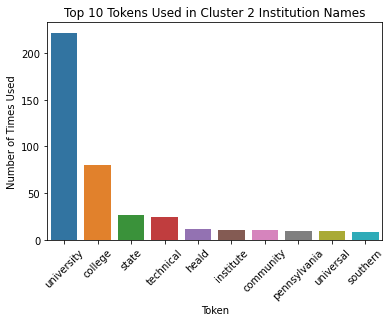

In [73]:
plot_common(freq, 2)

In [74]:
schools[schools.cluster == 2].sample(10)

,UNITID,INSTNM,CONTROL,NPT41_PUB,NPT41_PRIV,LO_INC_COMP_ORIG_YR6_RT,LO_INC_COMP_4YR_TRANS_YR6_RT,LO_INC_COMP_2YR_TRANS_YR6_RT,MN_EARN_WNE_INC1_P10,MN_EARN_WNE_INC2_P10,MN_EARN_WNE_INC3_P10,LO_INC_COMP_ORIG_OR_TRANS_YR6,LO_INC_COMP_ORIG_OR_TRANS_YR6_ROUND,NPT41_ALL,cluster
2120,179326,Southwest Baptist University,2,NaN,16941.0,0.368571,0.068571,NaN,33300.0,37200.0,42700.0,0.437143,0.4,16941.0,2.0
7298,484701,University of Phoenix-Missouri,3,NaN,19204.0,0.167921,0.035132,0.029575,39900.0,54000.0,76300.0,0.232628,0.2,19204.0,2.0
3507,218414,Newberry College,2,NaN,19434.0,0.344828,0.112069,NaN,34800.0,34300.0,43000.0,0.456897,0.5,19434.0,2.0
652,129215,Eastern Connecticut State University,1,13013.0,NaN,0.528571,0.082143,NaN,43000.0,48500.0,51400.0,0.610714,0.6,13013.0,2.0
2907,202763,The University of Findlay,2,NaN,17913.0,0.424581,0.145251,NaN,45100.0,49500.0,50400.0,0.569832,0.6,17913.0,2.0
6007,450483,University of Phoenix-Washington DC,3,NaN,17777.0,0.167921,0.035132,0.029575,39900.0,54000.0,76300.0,0.232628,0.2,17777.0,2.0
7173,482556,DeVry University-New Jersey,3,NaN,18025.0,0.144704,0.046495,0.035961,41700.0,52500.0,63600.0,0.227160,0.2,18025.0,2.0
7302,484747,University of Phoenix-Tennessee,3,NaN,17482.0,0.167921,0.035132,0.029575,39900.0,54000.0,76300.0,0.232628,0.2,17482.0,2.0
5336,438586,American InterContinental University-Atlanta,3,NaN,18575.0,0.263693,0.040381,0.031478,33700.0,47700.0,67200.0,0.335552,0.3,18575.0,2.0
847,137564,Southeastern University,2,NaN,18448.0,0.247934,0.177686,NaN,35300.0,36100.0,41700.0,0.425620,0.4,18448.0,2.0


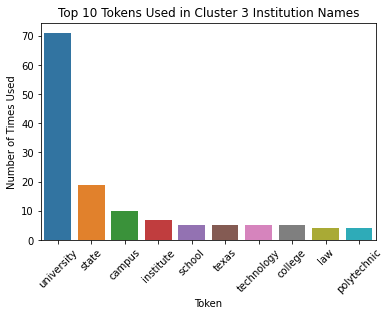

In [75]:
plot_common(freq, 3)

In [76]:
schools[schools.cluster == 3].sample(10)

,UNITID,INSTNM,CONTROL,NPT41_PUB,NPT41_PRIV,LO_INC_COMP_ORIG_YR6_RT,LO_INC_COMP_4YR_TRANS_YR6_RT,LO_INC_COMP_2YR_TRANS_YR6_RT,MN_EARN_WNE_INC1_P10,MN_EARN_WNE_INC2_P10,MN_EARN_WNE_INC3_P10,LO_INC_COMP_ORIG_OR_TRANS_YR6,LO_INC_COMP_ORIG_OR_TRANS_YR6_ROUND,NPT41_ALL,cluster
3650,221759,The University of Tennessee-Knoxville,1,8770.0,NaN,0.465463,0.073783,0.023548,63000.0,53000.0,54500.0,0.562794,0.6,8770.0,3.0
246,110653,University of California-Irvine,1,8532.0,NaN,0.626826,0.031873,NaN,66200.0,66900.0,64600.0,0.658699,0.7,8532.0,3.0
2622,196097,Stony Brook University,1,8770.0,NaN,0.606609,0.079465,0.012589,61300.0,62700.0,64200.0,0.698662,0.7,8770.0,3.0
2620,196079,Binghamton University,1,10585.0,NaN,0.668539,0.067416,NaN,65200.0,65300.0,71400.0,0.735955,0.7,10585.0,3.0
7512,16822702,Wentworth Institute of Technology,2,NaN,NaN,0.589109,0.069307,NaN,64100.0,66300.0,68700.0,0.658416,0.7,0.0,3.0
2320,186399,Rutgers University-Newark,1,7464.0,NaN,0.656680,0.050053,0.013747,73900.0,64900.0,66100.0,0.720479,0.7,7464.0,3.0
989,142522,Brigham Young University-Idaho,2,NaN,5374.0,0.441981,0.041038,0.012736,55900.0,42700.0,43400.0,0.495755,0.5,5374.0,3.0
3461,217402,Providence College,2,NaN,19136.0,0.523256,0.151163,NaN,71200.0,67400.0,75100.0,0.674419,0.7,19136.0,3.0
4292,243780,Purdue University-Main Campus,1,7153.0,NaN,0.641880,0.065812,0.013675,59700.0,58500.0,65100.0,0.721368,0.7,7153.0,3.0
247,110662,University of California-Los Angeles,1,8027.0,NaN,0.727966,0.020010,NaN,74300.0,72100.0,72800.0,0.747975,0.7,8027.0,3.0


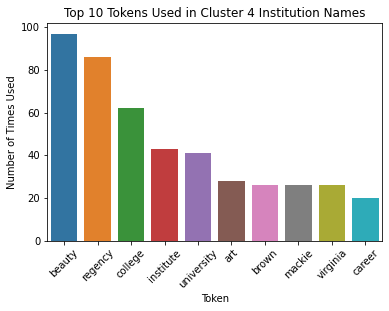

In [77]:
plot_common(freq, 4)

In [78]:
schools[schools.cluster == 4].sample(10)

,UNITID,INSTNM,CONTROL,NPT41_PUB,NPT41_PRIV,LO_INC_COMP_ORIG_YR6_RT,LO_INC_COMP_4YR_TRANS_YR6_RT,LO_INC_COMP_2YR_TRANS_YR6_RT,MN_EARN_WNE_INC1_P10,MN_EARN_WNE_INC2_P10,MN_EARN_WNE_INC3_P10,LO_INC_COMP_ORIG_OR_TRANS_YR6,LO_INC_COMP_ORIG_OR_TRANS_YR6_ROUND,NPT41_ALL,cluster
1943,174279,Minnesota School of Business-Richfield,3,NaN,18000.0,0.315083,0.032541,0.035124,29900.0,39700.0,44100.0,0.382748,0.4,18000.0,4.0
4896,410283,Brown Mackie College-Atlanta,3,NaN,20738.0,0.328638,0.085446,0.025352,29300.0,33100.0,35300.0,0.439437,0.4,20738.0,4.0
1971,175014,Rasmussen College-Minnesota,3,NaN,15604.0,0.266182,0.041108,0.024074,30000.0,38100.0,36900.0,0.331365,0.3,15604.0,4.0
6162,454388,Regency Beauty Institute-Grand Rapids,3,NaN,20710.0,0.480408,0.018776,0.053061,22500.0,25300.0,28100.0,0.552245,0.6,20710.0,4.0
4341,246974,Carrington College-San Leandro,3,NaN,17856.0,0.639113,NaN,0.023906,30300.0,36600.0,43300.0,0.663018,0.7,17856.0,4.0
6342,456834,Globe University-Minneapolis,3,NaN,15273.0,0.273050,0.029551,NaN,28700.0,34900.0,36200.0,0.302600,0.3,15273.0,4.0
4891,409670,Everest Institute-Kendall,3,NaN,19642.0,0.265282,0.026126,0.024619,25900.0,35300.0,38800.0,0.316027,0.3,19642.0,4.0
6291,456056,Virginia College-Charleston,3,NaN,15706.0,0.286405,0.027606,0.025855,24800.0,34700.0,38700.0,0.339867,0.3,15706.0,4.0
5409,440341,The Art Institute of Washington,3,NaN,23981.0,0.225205,0.045041,0.035032,33000.0,37900.0,37700.0,0.305278,0.3,23981.0,4.0
1205,151166,Harrison College-Indianapolis,3,NaN,21305.0,0.279800,0.029426,0.023940,23100.0,30200.0,32500.0,0.333167,0.3,21305.0,4.0


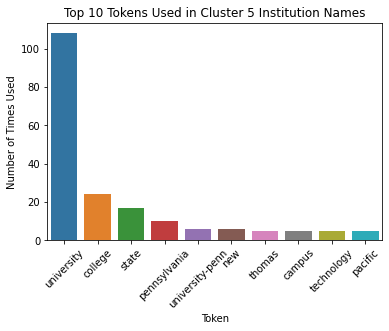

In [79]:
plot_common(freq, 5)

In [80]:
schools[schools.cluster == 5].sample(10)

,UNITID,INSTNM,CONTROL,NPT41_PUB,NPT41_PRIV,LO_INC_COMP_ORIG_YR6_RT,LO_INC_COMP_4YR_TRANS_YR6_RT,LO_INC_COMP_2YR_TRANS_YR6_RT,MN_EARN_WNE_INC1_P10,MN_EARN_WNE_INC2_P10,MN_EARN_WNE_INC3_P10,LO_INC_COMP_ORIG_OR_TRANS_YR6,LO_INC_COMP_ORIG_OR_TRANS_YR6_ROUND,NPT41_ALL,cluster
3273,212832,Gwynedd Mercy University,2,NaN,20686.0,0.480226,0.096045,NaN,49600.0,55500.0,58900.0,0.576271,0.6,20686.0,5.0
3447,216852,Widener University,2,NaN,23467.0,0.476395,0.103004,0.068670,63000.0,52100.0,61100.0,0.648069,0.6,23467.0,5.0
1093,146719,Loyola University Chicago,2,NaN,25348.0,0.652819,0.086053,NaN,67000.0,60200.0,63800.0,0.738872,0.7,25348.0,5.0
3980,233426,Roanoke College,2,NaN,22465.0,0.539474,0.171053,NaN,53600.0,47000.0,53800.0,0.710526,0.7,22465.0,5.0
2925,203368,John Carroll University,2,NaN,15303.0,0.582353,0.117647,NaN,52700.0,57900.0,64000.0,0.700000,0.7,15303.0,5.0
1564,161457,University of New England,2,NaN,25080.0,0.464286,0.100000,NaN,54700.0,48000.0,51600.0,0.564286,0.6,25080.0,5.0
3398,215655,Robert Morris University,2,NaN,18815.0,0.512545,0.053763,NaN,48400.0,52300.0,56700.0,0.566308,0.6,18815.0,5.0
3350,214713,Pennsylvania State University-Penn State Harri...,1,16141.0,NaN,0.480128,0.060973,0.039743,50800.0,53000.0,62300.0,0.580844,0.6,16141.0,5.0
277,112075,Concordia University-Irvine,2,NaN,21191.0,0.492424,0.075758,NaN,54100.0,48200.0,50700.0,0.568182,0.6,21191.0,5.0
3339,214591,Pennsylvania State University-Penn State Erie-...,1,16747.0,NaN,0.480128,0.060973,0.039743,50800.0,53000.0,62300.0,0.580844,0.6,16747.0,5.0


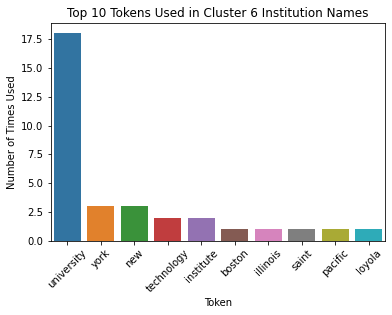

In [81]:
plot_common(freq, 6)

In [82]:
schools[schools.cluster == 6].sample(10)

,UNITID,INSTNM,CONTROL,NPT41_PUB,NPT41_PRIV,LO_INC_COMP_ORIG_YR6_RT,LO_INC_COMP_4YR_TRANS_YR6_RT,LO_INC_COMP_2YR_TRANS_YR6_RT,MN_EARN_WNE_INC1_P10,MN_EARN_WNE_INC2_P10,MN_EARN_WNE_INC3_P10,LO_INC_COMP_ORIG_OR_TRANS_YR6,LO_INC_COMP_ORIG_OR_TRANS_YR6_ROUND,NPT41_ALL,cluster
1662,164988,Boston University,2,NaN,22695.0,0.729508,0.059426,NaN,83300.0,74000.0,74500.0,0.788934,0.8,22695.0,6.0
393,117946,Loyola Marymount University,2,NaN,28306.0,0.715719,0.060201,NaN,85100.0,64100.0,67000.0,0.775920,0.8,28306.0,6.0
1715,166656,MCPHS University,2,NaN,28681.0,0.785388,0.059361,NaN,110900.0,108900.0,101100.0,0.844749,0.8,28681.0,6.0
3376,215132,University of the Sciences,2,NaN,14901.0,0.673684,0.147368,NaN,89700.0,89200.0,95000.0,0.821053,0.8,14901.0,6.0
2427,190150,Columbia University in the City of New York,2,NaN,9142.0,0.781667,0.028333,NaN,113500.0,115000.0,120000.0,0.810000,0.8,9142.0,6.0
4157,239105,Marquette University,2,NaN,21337.0,0.650862,0.112069,NaN,85700.0,68000.0,67500.0,0.762931,0.8,21337.0,6.0
1065,145725,Illinois Institute of Technology,2,NaN,15042.0,0.725410,0.069672,NaN,93800.0,69300.0,72400.0,0.795082,0.8,15042.0,6.0
803,135726,University of Miami,2,NaN,24792.0,0.719770,0.088292,NaN,73600.0,69900.0,74500.0,0.808061,0.8,24792.0,6.0
3239,212054,Drexel University,2,NaN,26588.0,0.518382,0.087010,0.014706,94200.0,72800.0,72700.0,0.620098,0.6,26588.0,6.0
2871,201645,Case Western Reserve University,2,NaN,14583.0,0.902439,0.024390,NaN,93100.0,96000.0,80700.0,0.926829,0.9,14583.0,6.0


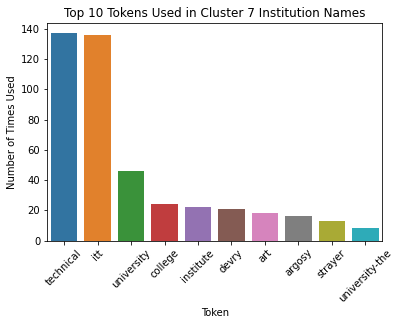

In [83]:
plot_common(freq, 7)

In [84]:
schools[schools.cluster == 7].sample(10)

,UNITID,INSTNM,CONTROL,NPT41_PUB,NPT41_PRIV,LO_INC_COMP_ORIG_YR6_RT,LO_INC_COMP_4YR_TRANS_YR6_RT,LO_INC_COMP_2YR_TRANS_YR6_RT,MN_EARN_WNE_INC1_P10,MN_EARN_WNE_INC2_P10,MN_EARN_WNE_INC3_P10,LO_INC_COMP_ORIG_OR_TRANS_YR6,LO_INC_COMP_ORIG_OR_TRANS_YR6_ROUND,NPT41_ALL,cluster
5354,439288,Johnson & Wales University-Denver,2,NaN,22573.0,0.445746,0.059803,0.027127,37200.0,41900.0,46100.0,0.532676,0.5,22573.0,7.0
1078,146393,Kendall College,3,NaN,30802.0,0.285714,0.043290,NaN,37300.0,40800.0,47500.0,0.329004,0.3,30802.0,7.0
368,117113,Argosy University-The Art Institute of Califor...,3,NaN,24394.0,0.169806,0.069955,0.027205,43800.0,44400.0,50500.0,0.266966,0.3,24394.0,7.0
5163,430351,ITT Technical Institute-Harrisburg,3,NaN,23505.0,0.277471,0.031034,0.018391,38400.0,48100.0,50600.0,0.326897,0.3,23505.0,7.0
5893,448734,Argosy University-Denver,3,NaN,19665.0,0.169806,0.069955,0.027205,43800.0,44400.0,50500.0,0.266966,0.3,19665.0,7.0
4501,366650,ITT Technical Institute-Knoxville,3,NaN,23918.0,0.277471,0.031034,0.018391,38400.0,48100.0,50600.0,0.326897,0.3,23918.0,7.0
5260,434566,ITT Technical Institute-Albany,3,NaN,22465.0,0.277471,0.031034,0.018391,38400.0,48100.0,50600.0,0.326897,0.3,22465.0,7.0
886,138947,Clark Atlanta University,2,NaN,30500.0,0.335677,0.142355,NaN,35100.0,37900.0,42800.0,0.478032,0.5,30500.0,7.0
6494,458937,Strayer University-Louisiana,3,NaN,27360.0,0.098301,0.041738,0.025202,39500.0,54200.0,74700.0,0.165241,0.2,27360.0,7.0
7165,482468,DeVry University-Georgia,3,NaN,25058.0,0.144704,0.046495,0.035961,41700.0,52500.0,63600.0,0.227160,0.2,25058.0,7.0


I conclude that the 5 most interesting clusters can *generally* be described as follows by adding to the original table:

| Cluster | Description | Control | Mean earnings (10 year) for low-income students (<mark style="background-color:#ffc2c2">Bad = low, median `<$40K`</mark>, <mark style="background-color:#c8ffc2">Good = high, median `>$60K`</mark>) | 6-year completion rate for low-income students (<mark style="background-color:#ffc2c2">Bad = low, median <30%</mark>, <mark style="background-color:#c8ffc2">Good = high, median >60%</mark>) | Mean net price for low-income students (<mark style="background-color:#ffc2c2">Bad = high, median `>$20K`</mark>, <mark style="background-color:#c8ffc2">Good = low, median `<$10K`</mark>) |
|---------|---------|------------------------------|------------------------------|------------------------------|------------------------------|
| 0 | Community colleges | Primarily public, but includes institutions of all 3 controls | <mark style="background-color:#ffc2c2">Low, Median `~$31K`</mark> | <mark style="background-color:#ffc2c2">Low, Median ~28%</mark> | <mark style="background-color:#c8ffc2">Low, Median `~$5K`</mark> |
| 1 | Public non-community colleges and satellite public university campuses | Primarily public, but includes institutions of all 3 controls | <mark style="background-color:#ffffc4">Mid, Median `~$41K`</mark> | <mark style="background-color:#cfcfcf">Minimal relationship between cluster and completion, Median ~45%</mark> | <mark style="background-color:#c8ffc2">Low, Median `~$8K`</mark> |
| 2 | Mid-ranked institutions, particularly nonprofit religious schools | Fairly evenly distributed across all 3 controls; however, the largest number of nonprofit institutions in any cluster is in this one | <mark style="background-color:#ffffc4">Mid, Median `~$40K`</mark> | <mark style="background-color:#cfcfcf">Minimal relationship between cluster and completion, Median ~45%</mark> | <mark style="background-color:#ffffc4">Mid, Median `~$15K`</mark> |
| 3 | Mid-to-highly-ranked public universities | Primarily public, but also includes nonprofit; no for-profit | <mark style="background-color:#c8ffc2">High, Median `~$65K`</mark> | <mark style="background-color:#c8ffc2">High, Median ~65%</mark> | <mark style="background-color:#c8ffc2">Low, Median `~$9K`</mark> |
| 4 | For-profit trade schools for trades that traditionally earn on the lower end, such as beauty and art | Primarily for-profit, but includes institutions of all 3 controls | <mark style="background-color:#ffc2c2">Low, Median `~$28K`</mark> | <mark style="background-color:#cfcfcf">Minimal relationship between cluster and completion, Median ~40%</mark> | <mark style="background-color:#ffffc4">Mid, Median `~$19K`</mark> |
| 5 | Mid-ranked nonprofit institutions | Primarily nonprofit, but includes institutions of all 3 controls | <mark style="background-color:#ffffc4">Mid, Median `~$52K`</mark> | <mark style="background-color:#c8ffc2">High, Median ~62%</mark> | <mark style="background-color:#ffc2c2">High, Median `~$20K`</mark> |
| 6 | Highly ranked nonprofit undergraduate health sciences-focused universities | All nonprofit | <mark style="background-color:#c8ffc2">High, Median `~$85K`</mark> | <mark style="background-color:#c8ffc2">High, Median ~75%</mark> | <mark style="background-color:#ffc2c2">High, Median `~$22K`</mark> |
| 7 | For-profit institutions often described as "predatory" (such as ITT Tech) | Primarily for-profit, but also includes nonprofit; no public | <mark style="background-color:#ffffc4">Mid, Median `~$40K`</mark> | <mark style="background-color:#ffffc4">Mid, Median ~30%</mark> | <mark style="background-color:#ffc2c2">High, Median `~$23K`</mark> |

Based on this analysis, I would conclude that:
- Mid-to-highly ranked public universities tend to be the most reliable in facilitating upward socioeconomic mobility for low-income students
- For-profit trade schools for lower-earning trades as well as "predatory" for-profit institutions are the least reliable in facilitating upward socioeconomic mobility for low-income students
- Community colleges may be inexpensive, but the likelihood of completing a degree and the earnings after completing that degree may not be worth the cost for low-income students